<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notes</a></span><ul class="toc-item"><li><span><a href="#Journal" data-toc-modified-id="Journal-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Journal</a></span></li><li><span><a href="#To-Do" data-toc-modified-id="To-Do-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>To Do</a></span></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Results-and-Metrics" data-toc-modified-id="Results-and-Metrics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Metrics</a></span></li><li><span><a href="#Investigating-low-performance" data-toc-modified-id="Investigating-low-performance-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Investigating low performance</a></span><ul class="toc-item"><li><span><a href="#Stepping-Through-a-Batch" data-toc-modified-id="Stepping-Through-a-Batch-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Stepping Through a Batch</a></span></li></ul></li></ul></div>

# Notes

The purpose of this notebook is to learn how to fine-tune my learner with fastai's built-in methods using PASCAL 2012 so I can benchmark myself against the 2018 course.

## Journal

- 2020-12-09 (Wed):
    - Created cocosample nb
    - Accomplishment: I figured out how to use a resnet50 backbone
    - I'm concerned that the results are pretty poor. I made a note to figure out why the predictions for remote are especially bad. Is it just that this dataset doesn't have people..?
    - The fastai 2018 course implementation of SSD achieved **.30** mAP on the PASCAL VOC 2007 dataset ([link here](https://forums.fast.ai/t/mean-average-precision-map/14345/16?u=mccallionr)). This makes me think I should aim for an mAP of .5 on the same dataset.
    - Created new nb (hello!) so I don't loose the results of the training on coco sample.
- 2020-12-10 (Thurs):
    - I've discovered two strong pieces of evidence that there's something wrong with the model.
        - The model gets the same result for lr=.002 and lr=.5
        - JH's loss was much lower than mine (val loss started at 14.6)
    - Idea for contribution: recreate the 2018 course nb very closely using fastai v2

## To Do

**Main things**
- 🟢Benchmark mAP using pascal 2007
- Check to see if bg is being properly handled in BCELoss.

**Laundry**
- Refactor ap_per_cls for use in metric and in ResultShower
- Consider refactoring SSD loss to use acts_to_preds
- show_bb should output colored text
- Set all devices in one go
- Change dls.vocab to be voc or v in places

# Data

In [ ]:
### Imports & Paths ###
from fastai.vision.all import *
import pandas as pd

path = untar_data(URLs.PASCAL_2007)
annos_path = path/'train.json'
ims_path = path/'train'

In [ ]:
### Params ###
im_sz   = 224
bs      = 64
val_pct = .2
sub_pct = 1

In [ ]:
### Items ###
fns, annos = get_annotations(annos_path)
fn2anno = {f:a for f,a in zip(fns,annos)}
def get_im(f):   return ims_path/f
def get_bbox(f): return fn2anno[f][0]
def get_lbl(f):  return fn2anno[f][1]

In [ ]:
### DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_x=get_im, get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(val_pct),
    item_tfms=Resize(im_sz, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats), n_inp=1)
subset = L(fns).shuffle()[0:int(len(fns)*sub_pct)]
dls = db.dataloaders(subset, bs=bs)
voc = dls.vocab
n_cls = len(voc)

In [ ]:
### Inspection ###
print("Vocab:",voc)
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Vocab: (#21) ['#na#','aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair'...]
Size of train data: 2001
Size of valid data: 500
batch[0]: 	 torch.float32 	 torch.Size([64, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([64, 16, 4])
batch[2]: 	 torch.int64 	 torch.Size([64, 16])


Interpretation of tensor shapes:
- torch.Size([128, 3, 224, 224]): bs, channels (rgb), im_sz, im_sz
- torch.Size([128, 20, 4]): bs, max objs for a single im in batch, bb coords
- torch.Size([128, 20]): bs, max objs for a single im in batch

# Model

In [ ]:
### Architecture ###
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    return x.permute(0,2,3,1).contiguous().view(bs,-1,nf//k)

def perm(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,3,2,1).contiguous()
    return x.view(bs, gx*gy*k, nf//k)

class StdConv(Module):
    """Wraps together the standard conv2d→ batchnorm→ dropout."""
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

class OutConv(Module):
    """Outputs two sets of acts: one for bbs, one for lbls."""
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.bb_acts  = nn.Conv2d(nin, 4*k,              3, padding=1)
        self.lbl_acts = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1)
        self.lbl_acts.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [flatten_conv(self.bb_acts(x), self.k),
                flatten_conv(self.lbl_acts(x),self.k)]         

class SSDHead(Module):
    """Wraps StdConv and OutConv into a head module.
       Defaults to resnet34 backbone."""
    def __init__(self, k, bias, drop, body='resnet34'):
        super().__init__()
        test(body, ['resnet34','resnet50'], operator.in_)
        self.body  = body
        self.drop  = nn.Dropout(drop)
        self.re_sz = StdConv(2048, 512, stride=1)
        self.conv0 = StdConv(512,256, drop=drop)
        self.out0  = OutConv(k,  256, bias)
        self.conv1 = StdConv(256,256, drop=drop)
        self.out1  = OutConv(k,  256, bias)
        self.conv2 = StdConv(256,256, drop=drop)
        self.out2  = OutConv(k,  256, bias)
        
    def forward(self, x):
        if self.body == 'resnet34': x = F.relu(x)
        x = self.drop(x)
        if self.body == 'resnet50': x = self.re_sz(x)
        x = self.conv0(x)
        bb0,lbl0 = self.out0(x)
        x = self.conv1(x)
        bb1,lbl1 = self.out1(x)
        x = self.conv2(x)
        bb2,lbl2 = self.out2(x)
        return [torch.cat([ bb0, bb1, bb2], dim=1),
                torch.cat([lbl0,lbl1,lbl2], dim=1)]

class CustMod(Module):
    """A module made from a pretrained body and an untrained head."""
    def __init__(self, body, head): self.body, self.head = body, head
        
    def forward(self, x): return self.head(self.body(x))

In [ ]:
### Anchors ###
def create_anchors(subdivs, zooms, ratios, device='cuda'):
    # create list of permutations per default anchor box
    perms = [(z*r1,z*r2) for z in zooms for (r1,r2) in ratios]
    k = len(perms)
    offsets = [1/(sd*2) for sd in subdivs]
    xs = np.concatenate([np.repeat(np.linspace(o, 1-o, sd), sd) for o,sd in zip(offsets, subdivs)])
    ys = np.concatenate([np.tile  (np.linspace(o, 1-o, sd), sd) for o,sd in zip(offsets, subdivs)])
    ctrs = np.repeat(np.stack([xs,ys], axis=1), k, axis=0)
    hws = np.concatenate([np.array([[o/sd,p/sd] for i in range(sd*sd) for o,p in perms]) for sd in subdivs])
    box_sizes = tensor(np.concatenate([np.array([1/sd for i in range(sd*sd) for o,p in perms])
                                      for sd in subdivs]), requires_grad=False).unsqueeze(1)
    anchors = tensor(np.concatenate([ctrs, hws], axis=1), requires_grad=False).float()
    return anchors.to(device), box_sizes.to(device)

def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1

In [ ]:
### IoU ###
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)

def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])

def get_iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union

Left off here!

Check to see if bg is being properly handled in BCELoss. I'm almost certain it isn't. Shouldn't the return be divided by n_cls-1 instead of n_cls?

In [ ]:
### FocalLoss ###
def one_hot_embedding(lbls, n_cls, device='cuda'):
    return torch.eye(n_cls)[lbls.data].to(device)

class BCELoss(nn.Module):
    def __init__(self, n_cls, device='cuda'):
        super().__init__()
        self.n_cls = n_cls
        self.device = device
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:]                # throw away bg preds
        t = one_hot_embedding(targ_lbl, self.n_cls, self.device)
        t = tensor(t[:,1:].contiguous()) # throw away bg lbls (there aren't any)
        w = self.get_weight(a,t).detach()
        return F.binary_cross_entropy_with_logits(a,t,w,reduction='sum')/(self.n_cls-1)
    
    def get_weight(self,a,t): return None 

class FocalLoss(BCELoss):
    def get_weight(self, a, t):
        alpha, gamma = 0.25, 2.0 # vals from paper
        p = a.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

In [ ]:
### ssd_loss ###
def remove_padding(bb, lbl):
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]

def get_pred_bbs(act_bb, ancs, anc_sz, device):
    ancs.to(device); anc_sz.to(device)
    acts = torch.tanh(act_bb)                   # make acts between -1 and 1
    ctrs = ancs[:,:2] + (acts[:,:2]/2 * anc_sz) # move ctrs by up to box_size/2
    hws  = ancs[:,2:] * (acts[:,2:]/2+1)        # adjust hw up to 1/2
    return create_anchor_boxes(ctrs, hws)

def map_to_gt(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return bb_idxs, max_iou_per_anc

def ssd_item_loss(act_bbs, act_lbls, bbs, lbls, device='cuda'):
    """SSD item loss takes single items from a minibatch, creates hundreds of preds, maps gt
       to the preds, prunes the preds, then calcs & returns the bb and lbl loss for that item."""
    # prep
    bbs,lbls = remove_padding(bbs,lbls)                      # remove gt padding inserted during training
    pred_bbs = get_pred_bbs(act_bbs,anchors,box_size,device) # make ~200 pred bbs from acts and ancs
    # map gt to preds
    iou_gt_grid = get_iou(bbs.data, anchor_boxes.data)       # get iou(gt_bbs,anc_bbs); used to map gt → ancs
    mapped_gt_idx, iou_gt_preds = map_to_gt(iou_gt_grid)     # assign each pred an index of a gt object
    mapped_bbs  = bbs[mapped_gt_idx]                         # project gt bbs into pred space
    mapped_lbls = lbls[mapped_gt_idx]                        # project gt lbls into pred space
    # remove low-iou bb preds & set mapped lbl to bg
    high_iou = iou_gt_preds > 0.4                            # only include bb preds that overlap w/a gt obj and
    incl = torch.nonzero(high_iou)[:,0]                      #  are not predicting background
    mapped_lbls[~high_iou] = 0                               # assign gt class of bg to preds w/ low max gt iou
    # compute loss
    bb_loss_val  = F.l1_loss(pred_bbs[incl], mapped_bbs[incl])
    lbl_loss_val = FocalLoss(n_cls, device)(act_lbls, mapped_lbls)
    return bb_loss_val, lbl_loss_val

def ssd_loss(b_acts, b_bbs, b_lbls, device='cuda'):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for o in zip(*b_acts, b_bbs, b_lbls):
        bb_loss, lbl_loss = ssd_item_loss(*o, device)
        sum_bb_loss  += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss

In [ ]:
### get_preds ###
def nms(boxes, scores, iou_thresh, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort asc
    idx = idx[-top_k:]       # indices of k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= iou_thresh
        idx = idx[IoU.le(iou_thresh)]
    return keep, count

def acts_to_preds(abb, albl, ancs, anc_sz, iou_thresh, conf_thresh, device):
    """Turn model acts into preds: abbs use get_pred_bbs, and albls use sigmoid().max().
       Used in ResultShower and mAP (and could possibly be used in loss fxn)."""
     # convert acts to preds
    pbb = get_pred_bbs(abb, ancs, anc_sz, device)
    conf, plbl = albl.sigmoid().max(1)
    # filter out preds w/ nms
    nms_idxs, nms_n = nms(pbb.data, conf, iou_thresh)
    nms_idxs = nms_idxs[:nms_n]
    pbb  = pbb[nms_idxs]
    plbl = plbl[nms_idxs]
    conf = conf[nms_idxs]
    # filter out bg and low-conf preds
    is_not_bg = (plbl!=0)
    is_confident = conf > conf_thresh
    mask = is_not_bg & is_confident
    return pbb[mask], plbl[mask], conf[mask]

def get_batch_preds(abb, albl, ancs, anc_sz, iou_thresh=.5, conf_thresh=.25, device='cpu'):
    """Loop through a batch and of activations and turn them into predictions."""
    ancs.to(device); anc_sz.to(device)
    pbbs, plbls, confs = [], [], []
    for abb, albl in zip(abb, albl):
        pbb, plbl, conf = acts_to_preds(abb,albl,ancs,anc_sz,iou_thresh,conf_thresh,device)
        pbbs  += [pbb]
        plbls += [plbl]
        confs += [conf]
    return pbbs, plbls, confs

In [ ]:
### Metric ###
def _format_inps(acts, batch, anchors, box_size, iou_thresh, conf_thresh, device):
    """Format acts and targs for AP score calc. Input expects learner.acts & learner.batch,
       output format: (im_idx, pred_bbs, pred_cls, cls_conf) and (im_idx, bbs, cls).
       Ex: (46.0, tensor([0.1, 0.2, 0.9, 0.9]), tensor(3), tensor(0.78))"""
    preds = get_batch_preds(*acts, anchors, box_size, iou_thresh, conf_thresh, device)
    p_idxs = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(preds[0])]).numpy().tolist()
    gt_idxs = torch.cat([torch.tensor([i]*len(o)) for i,o in enumerate(batch[1])]).numpy().tolist()
    batch_preds = list(zip(p_idxs, *[torch.cat(o) for o in preds]))
    batch_gts = list(zip(gt_idxs, *[o.flatten(end_dim=1) for o in batch[1:]]))
    return batch_preds, batch_gts

def _flatten_list(l, ret_L=False):
    """Flatten a list-of-lists; lists can be python `list`s or a fastai `L`s."""
    def _recur(l,res):
        for o in l:
            if   isinstance(o,list): _recur(o,res)
            elif isinstance(o,L)   : _recur(o,res)
            else: res.append(o)
        return res
    res = _recur(l, [])
    return res if not ret_L else L(res)

def _get_tp_bbs(preds_tp):
    """Output list of tp bbs per im in batch. Not used to calculate mAP; only
       used to grab true positive bb preds for visualizing in ResultShower."""
    # Each row in preds_tps is a formatted pred (see format_ap_inputs) and a list of
    # 1s and 0s (signifying tps and fps) for a cls. No preds for a cls → empty lists.
    batch_idxs, pred_bbs, tpfps = [], [], []
    for preds,tp in preds_tp:
        batch_idxs.append([o[0] for o in preds])
        pred_bbs.append([o[1] for o in preds])
        tpfps.append(tp)
    flat_idxs  = _flatten_list(batch_idxs)
    flat_bbs   = _flatten_list(pred_bbs)
    flat_tpfps = torch.cat(tpfps)

    scored_preds = list(zip(flat_idxs, flat_bbs, flat_tpfps))
    true_bbs = [(int(o[0]), o[1]) for o in scored_preds if o[2]==True]

    true_preds = [torch.zeros(4).view(1,4) for i in range(0,bs)]
    for i,bb in true_bbs:
        if true_preds[i].sum()==0: true_preds[i] = bb.view(1,4)
        else: true_preds[i] = torch.cat([true_preds[int(i)], bb.view(1,4)], dim=0)
    return true_preds

def ap_per_cls(acts, batch, n_cls, ancs, anc_sz, iou_thresh, conf_thresh, device='cuda'):
    """Calculate AP score per class. Returns avg AP over all classes."""
    batch_preds, batch_gts = _format_inps(acts,batch,ancs,anc_sz,iou_thresh,conf_thresh,device)
    # avg_precs holds ap per cls; other accumulators only used for vizing results
    avg_precs, preds_tp, n_objs_accum = [],[],[] 
    for c in range(1,n_cls): # start at 1 to ignore gt
        # store preds and gts for current cls
        preds = [b for b in batch_preds if b[2]==c]
        gts   = [b for b in batch_gts   if b[2]==c]
                
        # sort preds by conf desc
        preds.sort(key=lambda x: x[3], reverse=True)
        
        # make dict of im_idx:zeros(n_objs)
        n_objs = Counter([gt[0] for gt in gts])
        for k,v in n_objs.items(): n_objs[k] = torch.zeros(v)
        
        # init tp: a bool tensor for each im s.t. 1s indicate a pred is a tp
        tp = torch.zeros((len(preds))).bool()
        total_gt_objs = len(gts)
        
        for pred_idx, pred in enumerate(preds):
            gt_objs = [o for o in gts if o[0] == pred[0]]
            n_gt_objs = len(gt_objs)
            max_iou = 0
            
            for idx, gt in enumerate(gt_objs):
                iou = get_iou(pred[1].view(1,4), gt[1].view(1,4))
                if iou > max_iou: max_iou, idx_of_max = iou, idx
                    
            # update idx of gt_obj to indicate it's been used
            if max_iou > iou_thresh:
                if n_objs[pred[0]][idx_of_max]==0:
                    tp[pred_idx] = 1
                    n_objs[pred[0]][idx_of_max] = 1
                    
        # store tp_bbs: use tp ask mask on preds and take 1th item (the bb) from each
        preds_tp.append(([preds,tp]))
        n_objs_accum.append(n_objs)
        
        # calc avg_prec and store
        tps = torch.cumsum(tp, dim=0)               # 1. tp csum: [0,1,1,0,0] → [0,1,2,2,2]
        fps = torch.cumsum(~tp, dim=0)              # (basically same steps for fp)
        prec = torch.div(tps, (tps + fps + 1e-6))   # 2. divide each tps item by n_preds
        prec = torch.cat((torch.tensor([1]), prec)) # 3. slap on a 1 at the beginning
        rec = tps / (total_gt_objs + 1e-6)
        rec = torch.cat((torch.tensor([0]), rec))
        avg_prec = torch.trapz(prec, rec) # calc AP w/ trap rule
        avg_precs.append(avg_prec)        # store AP of this cls in accum
    return avg_precs, _get_tp_bbs(preds_tp), n_objs_accum

def get_ap_scores(dls, model, ancs, anc_sz, iou, conf, device='cpu'):
    for o in [dls, model, anchors, box_size]: o.to(device)
    model.eval()
    n_cls = len(dls.vocab)

    res=[]
    for b in dls.valid:
        scores,_,_ = ap_per_cls(model(b[0]),b,n_cls,ancs,anc_sz,iou,conf,device)
        res.append(scores)
    ap_scores = torch.stack([tensor(o) for o in res]).sum(axis=0)/len(res)
    ap_scores = ap_scores.numpy().tolist()
    return sum(ap_scores)/len(ap_scores), ap_scores

class MeanAveragePrecision(Metric):
    def __init__(self, func, n_cls):
        self.func,self.n_cls = func,n_cls
    def reset(self):
        self.res = []
    def accumulate(self, learn):
        is_last_epoch = learn.epoch==learn.n_epoch-1
        if is_last_epoch:
            cls_aps,_,_ = self.func(learn.pred,(*learn.xb,*learn.yb),self.n_cls,anchors,box_size)
            self.res.append(cls_aps)
    @property
    def value(self):
        if self.res==[]:
            return 0
        else:
            ap_scores = torch.stack([tensor(o) for o in self.res]).sum(axis=0)/len(self.res)
            return sum(ap_scores)/len(ap_scores)
    @property
    def name(self):
        return "mAP"

In [ ]:
### Viz Results ###
def show_bb(im, bb=None, lbl=[''], title=None, color='white',
            ctx=None, sz=im_sz, figsize=5):
    # process empties and nones
    if bb.shape[-1]==0 or bb==None: bb  = tensor([[0.,0,0,0]])
    if lbl==['']:                   lbl = ['']*bb.shape[0]
        
    # process tensors to take advantage of fastai show methods
    bbox = TensorBBox((bb+1)*sz//2)
    labeledbbox = LabeledBBox(bbox,lbl)
    
    if ctx:     show_image(im, figsize=[figsize,figsize], title=title, ctx=ctx)
    else: ctx = show_image(im, figsize=[figsize,figsize], title=title)
    
    labeledbbox.show(ctx=ctx)       # first, draw white lbl bbs...
    bbox.show(ctx=ctx, color=color) # ... then overlay color bbs.
    return ctx

def get_im_tpfpfns(res):
    """QnD function to output tpfpfns for each im in a batch given a ResultShower."""
    # TPs are found by counting 
    tps = []
    for bbs in res.tp_bbs:
        if bbs.sum()==0: tps.append(0)
        else: tps.append(bbs.shape[0])
    # FPs are found by subtracing tps from preds_per_im
    preds_per_im = [o.shape[0] for o in res.preds[0]]
    fps = [pred-tp for pred,tp in zip(preds_per_im, tps)]
    # FNs (relies on res.nobj which is a hack)
    # res.nobj is a dict where each key is a cls and the values are some combo of
    #  im_idx and a bool list st. the len of the list is the number of gt_objs for
    #  that class in that im, and the truth value of the bool represents whether
    #  the obj is a TP or FN.
    im_dict = defaultdict(lambda: [])
    for cls in res.nobj:
        for im_idx,tp_tensor in cls.items():
            im_dict[im_idx] += ~tp_tensor.bool()
    idx_fns = [(k,sum(v).item()) for k,v in im_dict.items()]
    idx_fns.sort()
    fns = [o[1] for o in idx_fns]
    return tps, fps, fns

class ResultShower():
    def __init__(self, dls, lrn, ancs, anc_sz, iou, conf):
        # store init's args
        self.dls    = dls
        self.mod    = lrn.model.eval().cpu()
        self.ancs   = ancs.cpu()
        self.anc_sz = anc_sz.cpu()
        self.iou    = iou
        self.conf   = conf
        # compute attrs
        self.batch    = next(iter(self.dls.cpu().valid))
        self.acts     = [a.data for a in self.mod(self.batch[0])]
        self.preds    = get_batch_preds(*self.acts,self.ancs,self.anc_sz,self.iou,self.conf,'cpu')
        self.dec_ims  = self.dls.decode(self.batch)[0]
        self.bs       = self.dls.bs
        self.voc      = self.dls.vocab
        self.im_sz    = self.batch[0].shape[-1]
        self.last_res = 0
        self.fig_sz   = [8,8]
        # compute metrics
        aps,tp_bbs,nobj = ap_per_cls(self.acts,self.batch,len(self.voc),
                                     self.ancs,self.anc_sz,self.iou,self.conf,'cpu')
        self.ap_scores  = [o.item() for o in aps]
        self.tp_bbs     = tp_bbs
        self.nobj       = nobj
        self.im_tpfpfns = get_im_tpfpfns(self)
        # clean up
        self.dls.cuda(); self.mod.cuda()
        
    def __call__(self, *args, **kwargs):
        return self.show_next(*args, **kwargs)
    
    def __getitem__(self, i):
        # get everything to draw
        ims             = self.dec_ims
        _,bbs,lbls      = self.batch
        pbbs,plbls,conf = self.preds
        tbbs            = self.tp_bbs
        tps,fps,fns     = self.im_tpfpfns
        # titles
        t_gt = f"Image {i} (obj={(lbls[i] > 0).sum()})"
        t_p  = f"TPs:{tps[i]} | FPs:{fps[i]} | FNs:{fns[i]}"
        # two ctx: gts and all preds. lime bbs drawn over TP preds.
        ctx = get_grid(2, figsize=self.fig_sz)
        show_bb(ims[i],bbs[i], self.voc[lbls[i]], t_gt,'white', ctx[0], self.im_sz)
        show_bb(ims[i],pbbs[i],self.voc[plbls[i]],t_p, 'magenta',ctx[1],self.im_sz)
        show_bb(ims[i],tbbs[i],color='lime',ctx=ctx[1])
                 
    def show_next(self, n=1):
        for i in range(n): self[(i + self.last_res)%self.bs]
        self.last_res += n

In [ ]:
# lil' helprs
def pad_strs(strs):
    nchars = [len(s) for s in strs]
    maxn = max(nchars)
    nspc = [maxn-n for n in nchars]
    return [s+' '*n for s,n in zip(strs,nspc)]
def print_lists(*lists):
    for l in [*lists]: test_eq(len(lists[0]), len(l))        # test lens eq
    pstrs = [pad_strs([str(o) for o in l]) for l in lists]   # get list of padding strs
    for zpstr in list(zip(*pstrs)): print(' | '.join(zpstr)) # print rows joined with ' | '
def batch_info(l):
    """Print idx, type, shape for items in l (a list of tensors)"""
    idxs = list(range(len(l)))
    shapes = apply(lambda t:t.shape, l)
    types = apply(type, l)
    print_lists(idxs, shapes, types)

# Train

In [ ]:
### Init Anchors ###
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])
met = MeanAveragePrecision(ap_per_cls, n_cls)

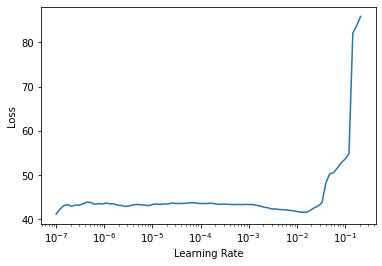

In [ ]:
def get_fresh_mod(k=k, bias=-4., drop=.4, body='resnet34', device='cuda'):
    test(body, ['resnet34','resnet50'], operator.in_)
    arch = resnet34 if body=='resnet34' else resnet50
    return CustMod(create_body(arch, pretrained=True), SSDHead(k, bias, drop, body))
mod = get_fresh_mod()
learner = Learner(dls, mod, loss_func=ssd_loss).to_fp16()
learner.freeze()
lr_min, lr_steep = learner.lr_find()

In [ ]:
lr = (lr_min+lr_steep)/2; print("lr:",round(lr,4))

lr: 0.0008


In [ ]:
learner.fit_one_cycle(10, lr=3e-3)

epoch,train_loss,valid_loss,time
0,42.482685,36.720375,00:09
1,38.248413,29.167881,00:09
2,32.885460,24.884941,00:09
3,28.996292,25.458496,00:09
4,26.612280,24.144314,00:09
5,24.728498,29.497557,00:09
6,24.188419,22.747478,00:09
7,22.809872,21.144314,00:09
8,21.448732,20.555954,00:09
9,20.428741,20.469698,00:09


In [ ]:
learner.save('s1')

Path('models/s1.pth')

In [ ]:
learner.export('models/20201211_pascal2007_focalfix.pkl')

In [ ]:
# learner.export('models/20201210_pascal2007.pkl')      # trained for 10 epochs
# learner.export('models/20201210_pascal2007_bad.pkl')  # trained for 5 epochs
# learner.export('models/20201211_pascal2007_focalfix.pkl') # corrected weight in focal loss

# Results and Metrics

Previous results:
- `load_learner(string of relative path to pkled model)`
- models/20201210_pascal2007.pkl: .229
- models/20201210_pascal2007_bad.pkl: .065
- models/20201211_pascal2007_focalfix.pkl: unsure

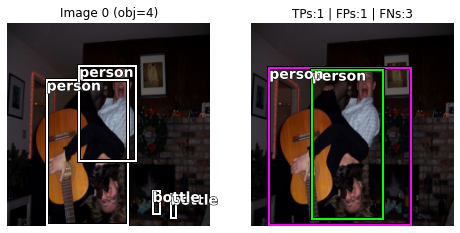

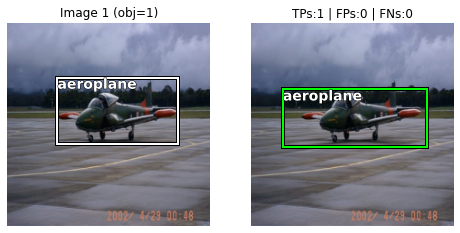

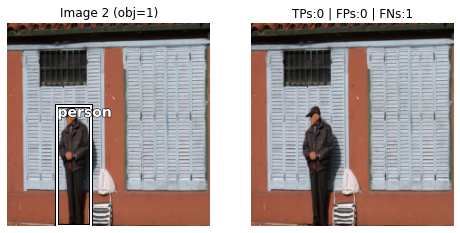

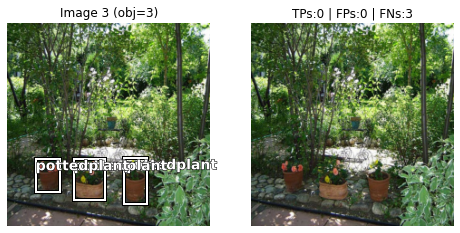

In [ ]:
results = ResultShower(dls, learner, anchors, box_size, .5, .3)
results(4)

In [ ]:
def test_confs(confs):
    for conf in confs:
        final,_ = get_ap_scores(dls, learner.model, anchors.cpu(), box_size.cpu(), .5, conf, 'cpu')
        print(f"mAP for conf {conf}: {round(final,3)}")
confs = [round(.05*x,2) for x in range(1,11)]
test_confs(confs)

mAP for conf 0.15: 0.081
mAP for conf 0.2: 0.078
mAP for conf 0.25: 0.076
mAP for conf 0.3: 0.071
mAP for conf 0.35: 0.053
mAP for conf 0.4: 0.024
mAP for conf 0.45: 0.013
mAP for conf 0.5: 0.006


**Left off here.** There's something really off about the above list. I'll have to come back to it.

In [ ]:
# show ap per cls, desc
final, ap_scores = get_ap_scores(dls, learner.model, anchors.cpu(), box_size.cpu(), iou, conf, device)
print("mAP:",round(final,3))
pd.DataFrame({'Class':voc[1:], 'AP':[round(o,3) for o in ap_scores]}).sort_values('AP',ascending=False)

mAP: 0.076


,Class,AP
6,car,0.252
0,aeroplane,0.216
12,horse,0.191
7,cat,0.182
14,person,0.166
18,train,0.142
13,motorbike,0.132
2,bird,0.078
17,sofa,0.076
11,dog,0.033


# Investigating low performance

Ideas (turn into hypotheses and test):
- not freezing the model properly
- problem with n_cls / not handling bg class properly everywhere
- problem in transpose
- problem in one output conv but not others?
- something wrong with loss fxn

I think something is off because I was able to get OK results by training the same architecture on 50% of the entire COCO dataset (55k training ims). My intuition is that it would be harder to train a model to detect 80 different classess of objects on 55k ims than training a model to det 6 cls of objs on 22k ims.

What I'm noticing about the visualized results:
- Almost zero predictions for remotes
- Possibly fewer predictions in general (fewer FPs and FNs)

## Stepping Through a Batch

In [ ]:
device='cpu'

In [ ]:
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios, device)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])
def get_fresh_mod(k=k, bias=-4., drop=.4, body='resnet34', device='cuda'):
    test(body, ['resnet34','resnet50'], operator.in_)
    arch = resnet34 if body=='resnet34' else resnet50
    return CustMod(create_body(arch, pretrained=True), SSDHead(k, bias, drop, body))

##### get batch, acts

In [ ]:
batch = next(iter(dls.cpu().valid))
mod = get_fresh_mod(device=device)
mod.eval()
acts = mod(batch[0])

##### ssd_loss

In [ ]:
b_acts = acts
b_bbs, b_lbls = batch[1], batch[2]

In [ ]:
ssd_loss(b_acts, b_bbs, b_lbls, device)

tensor(37.7575, grad_fn=<AddBackward0>)

In [ ]:
act_bbs, act_lbls, bbs, lbls = list(zip(*b_acts, b_bbs, b_lbls))[0]

##### ssd_item_loss

In [ ]:
# prep
bbs,lbls = remove_padding(bbs,lbls)                      # remove gt padding inserted during training
pred_bbs = get_pred_bbs(act_bbs,anchors,box_size,device) # make ~200 pred bbs from acts and ancs

In [ ]:
# map gt to preds
iou_gt_grid = get_iou(bbs.data, anchor_boxes.data)       # get iou(gt_bbs,anc_bbs); used to map gt → ancs
iou_gt_grid

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.7437e-02, 1.1700e-01,
         1.5487e-01],
        [1.0728e-02, 2.7533e-04, 6.5517e-03,  ..., 3.9946e-01, 5.3391e-01,
         5.4951e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2606e-03, 4.5211e-03,
         4.5211e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2110e-03, 4.4219e-03,
         4.4219e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8496e-03, 3.6991e-03,
         1.7186e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.5702e-02, 5.1405e-02,
         1.0358e-02]])

In [ ]:
mapped_gt_idx, iou_gt_preds = map_to_gt(iou_gt_grid)     # assign each pred an index of a gt object
mapped_gt_idx, iou_gt_preds

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1,
         1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4,
         2, 2, 4, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         5, 5, 5, 1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
         0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]),
 tensor([1.0728e-02, 2.7533e-04, 6.5517e-03, 2.0640e-02, 4.5027e-03, 1.4241e-02,
         3.4927e-02, 1.1149e-02, 2.6063e-02, 1.9900e+00, 3.9043e-01, 4.0468e-01,
         6.6532e-01, 4.5201e-01, 6.1507e-01, 4.1124e-01, 4.5778e-01, 6.5092e-01,
         4.3168e-02, 2.1676e-02, 2.6038e-02, 6.8058e-02, 3.4415e-02, 4.6291e-02,
         1.0360e-01, 5.3011e-02, 7.

In [ ]:
mapped_bbs  = bbs[mapped_gt_idx]                         # project gt bbs into pred space
mapped_lbls = lbls[mapped_gt_idx]                        # project gt lbls into pred space
mapped_bbs, mapped_lbls

(tensor([[-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.9440, -0.4551, -0.5720,  0.0120],
         [-0.9440, -0.4551, -0.5720,  0.0120],
         [-0.9440, -0.4551, -0.5720,  0.0120],
         [-0.9440, -0.4551, -0.5720,  0.0120],
         [-0.9440, -0.4551, -0.5720,  0.0120],
         [-0.9440, -0.4551, -0.5720,  0.0120],
         [-0.9440, -0.4551, -0.5720,  0.0120],
         [-0.9440, -0.4551, -0.5720,  0.0120],
         [-0.9440, -0.4551, -0.5720,  0.0120],
         [-0.9440, -0.4551, -0.5720,  0.0120],
         [-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.8760, -0.6587,  0.7520,  1.0000],
         [-0.

In [ ]:
# remove low-iou bb preds & set mapped lbl to bg
high_iou = iou_gt_preds > 0.4                            # only include bb preds that overlap w/a gt obj and
high_iou

tensor([False, False, False, False, False, False, False, False, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False,  True, False, False, False, False, False, False, 

In [ ]:
incl = torch.nonzero(high_iou)[:,0]                      #  are not predicting background
incl

tensor([  9,  11,  12,  13,  14,  15,  16,  17,  85, 117, 121, 180, 181, 182,
        183, 184, 185, 187, 188])

In [ ]:
mapped_lbls[~high_iou] = 0                               # assign gt class of bg to preds w/ low max gt iou
mapped_lbls

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  7,  7,  7,  7,  7,  7,  7,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  7,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        13, 13, 15, 13, 13, 13,  0, 13, 13])

In [ ]:
# compute loss
bb_loss_val  = F.l1_loss(pred_bbs[incl], mapped_bbs[incl])
bb_loss_val

tensor(0.1592, grad_fn=<L1LossBackward>)

##### FocalLoss

In [ ]:
lbl_loss_val = FocalLoss(n_cls, device)(act_lbls, mapped_lbls)
lbl_loss_val

tensor(0.8983, grad_fn=<DivBackward0>)

In [ ]:
n_cls, voc

(21,
 (#21) ['#na#','aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair'...])

In [ ]:
act_lbls.shape, act_lbls

(torch.Size([189, 21]),
 tensor([[-3.9764, -3.7518, -4.2036,  ..., -3.9973, -3.8302, -4.1610],
         [-4.0052, -4.0246, -3.8691,  ..., -4.0878, -3.8216, -4.2565],
         [-4.1060, -4.5796, -3.9548,  ..., -3.6829, -3.8718, -3.7471],
         ...,
         [-3.9795, -4.0068, -3.9914,  ..., -4.0022, -4.0101, -4.0021],
         [-4.0049, -3.9944, -3.9913,  ..., -4.0069, -4.0223, -3.9895],
         [-3.9865, -3.9913, -4.0148,  ..., -3.9932, -3.9618, -4.0007]],
        grad_fn=<SelectBackward>))

In [ ]:
mapped_lbls.shape, mapped_lbls

(torch.Size([189]),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  7,  7,  7,  7,  7,  7,  7,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  7,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         13, 13, 15, 13, 13, 13,  0, 13, 13]))

In [ ]:
### FocalLoss ###
def one_hot_embedding(lbls, n_cls, device='cuda'):
    return torch.eye(n_cls)[lbls.data].to(device)

class BCELoss(nn.Module):
    def __init__(self, n_cls, device='cuda'):
        super().__init__()
        self.n_cls = n_cls
        self.device = device
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:] # throw away bg predictions
        t = one_hot_embedding(targ_lbl, self.n_cls, self.device)
        t = tensor(t[:,1:].contiguous())
        w = self.get_weight(a,t)
        return F.binary_cross_entropy_with_logits(a,t,w,reduction='sum')/(self.n_cls-1)
    
    def get_weight(self,a,t): return None 

class FocalLoss(BCELoss):
    def get_weight(self, a, t):
        alpha, gamma = 0.25, 2.0 # vals from paper
        p = a.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

In [ ]:
act_lbl, targ_lbl = act_lbls,mapped_lbls

In [ ]:
a = act_lbl[:,1:]
a.shape, a

(torch.Size([189, 20]),
 tensor([[-3.7518, -4.2036, -4.2439,  ..., -3.9973, -3.8302, -4.1610],
         [-4.0246, -3.8691, -4.2059,  ..., -4.0878, -3.8216, -4.2565],
         [-4.5796, -3.9548, -3.8192,  ..., -3.6829, -3.8718, -3.7471],
         ...,
         [-4.0068, -3.9914, -4.0146,  ..., -4.0022, -4.0101, -4.0021],
         [-3.9944, -3.9913, -3.9973,  ..., -4.0069, -4.0223, -3.9895],
         [-3.9913, -4.0148, -3.9937,  ..., -3.9932, -3.9618, -4.0007]],
        grad_fn=<SliceBackward>))

In [ ]:
t = one_hot_embedding(targ_lbl, n_cls, device)
t.shape, t

(torch.Size([189, 21]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
t = tensor(t[:,1:].contiguous())
t.shape, t

(torch.Size([189, 20]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
def get_weight(a, t):
    alpha, gamma = 0.25, 2.0 # vals from paper
    p = a.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
w = get_weight(a,t)

In [ ]:
F.binary_cross_entropy_with_logits(a,t,w,reduction='sum')/(n_cls-1)

RuntimeError: the derivative for 'weight' is not implemented